In [1]:
from audioFunctions import *
from binaryFunctions import *
from qam import *
from sequenceGenerators import *
from receiver import *
from error_coding import *
from to_import import *

In [2]:
CE_binary = binaryTextFileToBinary('Data_Files/random_bits.txt')
#binary = fileToBinary('Data_Files/kokoro_text.txt')
binary = binaryTextFileToBinary('Data_Files/kokoro_bin.txt')

CE_symbols = qpsk(CE_binary)
symbols = qpsk(Hamming74(binary))
#symbols = qpsk(binary)

In [3]:
'''text_file = open("Data_Files/kokoro_bin.txt", "w")
n = text_file.write(binary)
text_file.close()'''
print(len(symbols)/(2048))

1362.5048828125


In [6]:
# So far this works the best at estimating the location... 
chirp_signal = Chirp(500,20500,1, volume = 100)

In [7]:
# Set the parameters for transmission
CP = 704 
N = 4096
guard = 5
CE_repeat = 20

frame_data_length = 180

In [8]:
# For channel esimation (CE)

# prepare channel esitimation data to be transmitted 
CE_Time, CE_Freq = ofdmSymbols(CE_symbols, CP, N)
print(CE_Time.shape)


## THIS IS WHERE I NEED TO INCLUDE KISEKI's FUNCTION

Payload_Time, Payload_Freq = ofdmSymbols(symbols, CP, N)



extra = frame_data_length - len(Payload_Time)%frame_data_length
print(len(Payload_Time), extra)
for i in range(extra):
    Payload_Time = np.concatenate((Payload_Time, [CE_Time[1]]))
    
num_of_frames = int(len(Payload_Time)/frame_data_length)

print(num_of_frames)

(3, 4800)
1364 76
8


In [9]:
# Prepare what to transmit

# Channel estimation at the beginning
CE_transmit = repeat_signal(CE_Time[0], CE_repeat)
known_freq = CE_Freq[0]

# Payload mixed with CE symbols distributed between them
Payload = prepare_payload_std(Payload_Time, CE_transmit, chirp_signal, num_of_frames, frame_data_length)

num_of_frames = 2
Payload = Payload[:num_of_frames]

In [10]:
x = save_transmit( tuple(Payload) , playOutput=True)
print("Transmit signal is ", round(len(x)/fs, 2), " seconds")

playing
[0, 1]
[32767 32696 32486 ... -8714  5897   935]
Transmit signal is  46.0  seconds


In [27]:
sec = math.ceil(len(x)/fs) + 4
#y = record_and_save('audio_modem_test.wav', sec)
#y = audioDataFromFile('recorded_data_' + location + '.wav')
y = audioDataFromFile('Wav_Files/long_recording.wav')


In [28]:
y = audioDataFromFile('Wav_Files/long_recording.wav')


data_index_length = frame_data_length * (N+CP)
CE_index_length = CE_repeat * (N+CP)

freq_data = []
# big loop to find out everything
for i in range(num_of_frames):
    # obtain only the time series we are interested in 
    y_data = removeChirpAndPause_std(y, chirp_signal, 400000, plot = False, rng = 100)
    
    # Slice the data to retrieve the CE
    CE_samples, CE_freq, remaining = sliceData(y_data, CP-guard, N, CP, CE_repeat)
    CE_samples_end, CE_freq_end, remaining_end \
                    = sliceData(y_data[data_index_length + CE_index_length:], CP-guard, N, CP, CE_repeat)
    
    
    # Examine any phase shift 
    impulse_front, TF_front = getTF_FreqAverage(CE_freq, known_freq, N, CE_repeat)
    impulse_end, TF_end = getTF_FreqAverage(CE_freq_end, known_freq, N, CE_repeat)


    start_index = 0
    end_index = start_index + 2048
    TF_front_relevant =TF_front[start_index:end_index]
    TF_end_relevant = TF_end[start_index:end_index]
    
    '''
    for i in range(len(TF_end_roll)):
        TF_end_roll[i] = TF_end_roll[i]#* cmath.rect(1, (2*math.pi/4096)* (i*3.33 + 8.61))
        
    '''    
    angle_front = np.unwrap(np.angle(TF_front_relevant))
    angle_end = np.unwrap(np.angle(TF_end_relevant))

    difference = []
    for p, val in enumerate(angle_end):
        difference.append(round(val - angle_front[p], 3))
    '''    
    print(difference[:15])
    print(difference[-15:])

        
    diff = np.transpose(np.stack((difference, np.ones(np.array(difference).shape))))
    x = np.linspace(start_index, end_index, end_index- start_index)
    param = scipy.linalg.lstsq(diff, x)

    plot_y(difference[:1024], f = i+100, title = i)
    plot_y(angle_front, f = i, title = i)
    plot_y(angle_end, f= i)
    
    plt.figure(1000)
    plt.yscale("log")
    plt.plot(abs(np.array(TF_front))[:2048])
    plt.plot(abs(np.array(TF_end))[:2048])
    plot_y(abs(np.array(TF_front))[:2048], f=2)
    
    '''
    stable_phase_start = 200
    stable_phase_length = 200
    p = np.linspace(stable_phase_start,   stable_phase_start + stable_phase_length,   stable_phase_length)
    q = difference[stable_phase_start:   stable_phase_start + stable_phase_length  ]
    
    param = np.polyfit(p,q,1)
    print("param ", param)
    grad = param[0]
    
    if i == 0:
        freq_data = sliceDataContent_std(TF_front, TF_end, remaining, CP-guard, N, CP, frame_data_length, grad)
    else:
        freq_data = np.concatenate((freq_data, \
                        sliceDataContent_std(TF_front, TF_end, remaining, CP-guard, N, CP, frame_data_length, grad)))
    
    y = remaining_end

param  [-0.00742644  6.27147075]
param  [-0.00766976 -0.00990209]


In [30]:
print(freq_data.shape)

(360, 2047)


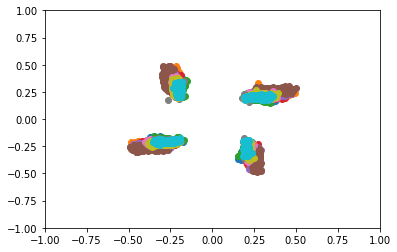

In [31]:
for i in range(10):
    plot_res = np.array(freq_data[i+150])[200:1500]
    plt.scatter(plot_res.real, plot_res.imag)
    window = 1
    plt.xlim(-1*window,window)
    plt.ylim(-1*window, window)

In [32]:
print(len(freq_data))
data1 = np.concatenate(tuple(freq_data))#[4*20:4*40]
predict = iHamming74(iqpsk(data1))

correct = 0
for i, val in enumerate(predict):
    if val == binary[i]:
        correct += 1

print(correct/len(predict))
    

360
0.9169773638315254


In [20]:
data1 = np.concatenate(tuple(freq_data[:100]))#[4*20:4*40]
predict = iHamming74(iqpsk(data1))
str_to_bytearray(predict).decode('utf-8', 'replace')

'0art 1: Sensei and I    I ALWAYS called him "Sensei." [note1] I shall therefore refer to him simply as "Sensei," and not by his real name. It is not because I consider it more discreet, but it is because I find it more natural that I do so. When�6`<��G\x10�����\x17f�Y�ˇ��\x18od��O��\x19���@Zʚ�h\x14��8�U�)nd that I think of him as "Sensei" still. And with pen in hand, I cannot bring myself to write of him in any other way.  It was at Kamakura, during the summer holidays, that I first met Sensei. I was then a very young student. I went there at vj�\x00\'�[�3�Bs88��Za\x08h��a�\x13�\x00���T��7�#A�ǪO�L�y\x12�.\nto Kamakura to swim. We were not together for long. It had taken me a few days to get together enough money to cover the necessary expenses, and it was only three days after my arrival that my friend received a telegram from home demanding his r`6}q�\x12�\x0c�\x0f\x02>!�A�=7\x12��[�np�Z\tZ�B�\\c]2�Y�ˍ���_�ill. My friend, however, did not believe this. For some time his parents had b

In [15]:
# obtain only the time series we are interested in 
y_data = removeChirpAndPause(y, chirp_signal, plot = False, rng = 40)

In [11]:
# Slice the data to retrieve the CE
CE_samples, CE_freq, remaining = sliceData(y_data, CE_CP-guard, CE_N, CE_CP, CE_repeat)

In [12]:
# getImpulseSimple(freq, known_freq, N, repeat)
impulse_simple, TF = getTF_FreqAverage(CE_freq, known_freq, CE_N, CE_repeat)

In [156]:
TF_ground = fft(np.roll(impulse_simple, 0))

In [136]:
'''plt.yscale("log")
plt.plot(abs(np.array(TF))[:2048])
plot_y(abs(np.array(TF))[:2048], f=2)
plot_y(impulse_simple[:500], f=0)'''

'plt.yscale("log")\nplt.plot(abs(np.array(TF))[:2048])\nplot_y(abs(np.array(TF))[:2048], f=2)\nplot_y(impulse_simple[:500], f=0)'

In [ ]:
start_index = 200
end_index = start_index + 512
TF_front_roll = fft(np.roll(impulse_front, -1*guard-3))[start_index:end_index]
TF_end_roll = fft(np.roll(impulse_end, -1*guard-3))[start_index:end_index]

angle_front = np.angle(TF_front_roll)
angle_end = np.angle(TF_end_roll)

difference = []
for p, val in enumerate(angle_front):
    difference.append(val - angle_end[p])

diff = np.transpose(np.stack((difference, np.ones(np.array(difference).shape))))

print(diff.shape)
x = np.linspace(start_index, end_index, end_index- start_index)

param = scipy.linalg.lstsq(diff, x)

plot_y(difference, f = i+100, title = i)
print(param)

plot_y(angle_front, f = i, title = i)
plot_y(angle_end, f= i)

In [465]:
def sliceDataContent(TF, data, timeshift_data, timeshift_CE, N_data, K_data, N_CE, K_CE, pilot_symbol_freq, total_data_symbol):
    data_length = N_data + K_data
    CE_length = N_CE + K_CE

    # block of PL1, PL2, ... , PLx , CE
    data_block_len = data_length*(pilot_symbol_freq - 1) + CE_length
    
    # number of these COMPLETE blocks in the data sequence
    num_data_block = math.floor(total_data_symbol/(pilot_symbol_freq-1)) 
    remaining_symbols = total_data_symbol - num_data_block * (pilot_symbol_freq-1)
    
    received_modulated_data = []
    # for every block of data we have
    for i in range(num_data_block + 1):
        
        # For any remainders
        if i == num_data_block and remaining_symbols != 0:
    
            remainder_block_len = data_length * remaining_symbols
            block = data[i*data_block_len:i*data_block_len + remainder_block_len + CE_length]
            
            impulse_local, TF_local = getTF_SingleSymbol(block[-1*CE_length:], known_freq, CE_N, timeshift_CE)
            
            ### MAYBE DO SOMETHING LIKE COMPARE THE PHASE OF THIS ONE TO THE INITIAL ONE BUT RIGHT NOW IT'S FINE :P

            symbols_in_block = remaining_symbols
            
        # normal procedure
        else:
            
            # get the particular data block in question
            block = data[i*data_block_len:(i+1)*data_block_len]

            # find the TF in this block
            impulse_local, TF_local = getTF_SingleSymbol(np.roll(block[-1*CE_length:],0), known_freq, CE_N, timeshift_CE)

            ### MAYBE DO SOMETHING LIKE COMPARE THE PHASE OF THIS ONE TO THE INITIAL ONE BUT RIGHT NOW IT'S FINE :P

            symbols_in_block = pilot_symbol_freq-1
            
        
        start_index = 200
        end_index = 200 + 512
        TF_local_roll = fft(np.roll(impulse_local, -1*guard-3))[start_index:end_index]
        TF_roll = fft(np.roll(impulse_simple, -1*guard-3))[start_index:end_index]
        
        angle_local = np.angle(TF_local_roll)
        angle_reference = np.angle(TF_roll)
        
        difference = []
        for p, val in enumerate(angle_local):
            difference.append(val - angle_reference[p])
        
        x = np.linspace(start_index, end_index, end_index- start_index)
        param = np.polyfit(x, difference, 1)
        
        plot_y(difference, f = i+100, title = i)
        print(param, i)
        
        #plot_y(angle_local, f = i, title = i)
        #plot_y(angle_reference, f= i)
        # for every Payload symbol in this data block 
        for j in range(symbols_in_block):
            
            samples_content = np.array(block[ data_length*j : data_length*(j+1) ][timeshift_data:timeshift_data+N_data]) 
            freq_content = fft(samples_content)
            

            response = np.zeros(int((Payload_N/2) - 1), dtype = complex)

            for k in range(1,int(len(freq_content)/2)):
                div = (freq_content[k]/TF[k]) * cmath.rect(1,2*math.pi * k * ((i+1)*0.15+(j+1)*0.05)) # <- Add phase correction
                response[k-1] += div
        
            received_modulated_data.append(np.array(response))
            
            
    return received_modulated_data



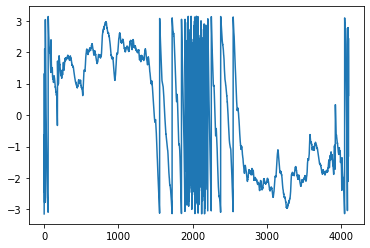

In [466]:
TF_roll = fft(np.roll(impulse_simple, -1*guard-3))
plot_y(np.angle(TF_roll))

[-0.00044074  0.00155041] 0
[-0.00078566  0.00276869] 1
[-0.0011265  0.0020458] 2
[-0.00145955  0.00330978] 3
[-0.00162796  0.00250128] 4


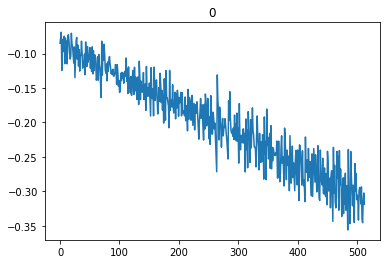

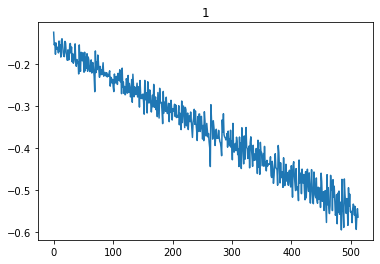

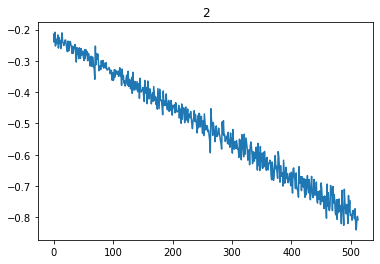

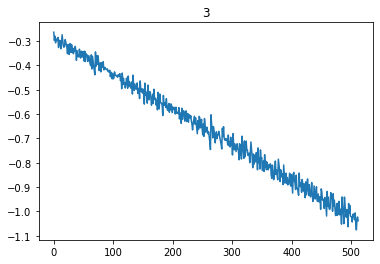

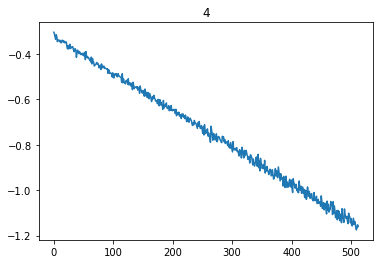

In [467]:
freq_data = sliceDataContent(TF, remaining, Payload_CP-guard, CE_CP-guard,Payload_N, Payload_CP, CE_N, CE_CP, pilot_symbol_freq, len(Payload_Time))

In [440]:
print(cmath.rect(2,0) * cmath.rect(1, math.pi/4))

(1.4142135623730951+1.414213562373095j)


(-1, 1)

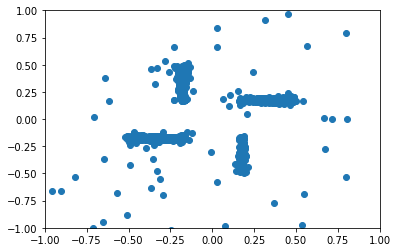

In [383]:
plot_res = np.array(freq_data[11])
plt.scatter(plot_res.real, plot_res.imag)
window = 1
plt.xlim(-1*window,window)
plt.ylim(-1*window, window)

In [384]:
a = np.array([[1],[2],[3]])

print(a)
print(tuple(a))

[[1]
 [2]
 [3]]
(array([1]), array([2]), array([3]))


In [385]:
print(freq_data[10][:20])
for i in range(1,13):
    data1 = np.concatenate(tuple(freq_data[:i]))#[4*20:4*40]
    predict = iHamming74(iqpsk(data1))

    correct = 0
    for i, val in enumerate(predict):
        if val == binary[i]:
            correct += 1

    print(correct/len(predict))

[ 2.8424007 +0.09547697j -3.34264146+3.47218229j  3.75417416+4.26118748j
 -9.15565241-6.91538573j  0.38062853-1.34293105j -0.08999502+0.21431284j
 -0.11040666-0.08648341j -0.13706711+0.04750916j  0.20052641+0.14903585j
  0.23404849+0.20548286j  0.14754628+0.45327392j  0.18920313+0.09962301j
 -0.15314588-0.21251903j  0.20396985+0.15294621j -0.16730872-0.15419757j
 -0.15271293+0.17213445j  0.16602622-0.16564654j  0.18373944-0.13171872j
 -0.15859582+0.18539172j -0.15579833+0.17837777j]
0.9696061643835616
0.9659965782720273
0.9670752565564424
0.9661179991449337
0.9658857729138167
0.9657309774864634
0.9659257449926723
0.9663317657118426
0.9661314839445183
0.9661850205198358
0.9663065443805379
0.9665859219150755


In [391]:
data1 = np.concatenate(tuple(freq_data))#[4*20:4*40]
predict = iHamming74(iqpsk(data1))
str_to_bytearray(predict).decode('utf-8', 'replace')

'�y heart is beating from me, I am standing all alone, Please call me only if you are coming home, Waste another year flies by, Waste a night or two, You taught me how to live In the streets of shame, Where you\'ve lost your dreams in the rain, There\'s no signs of hope, The sr\x1b�FW@^�J�K�\x06��}�]�he last of the dope, There\'s a glow of light, The St. Jimmy is the spark in the night, Bearing gifts and trust, The fixture in the city of lust, "What the hells your name, What\'s your pleasure and what\'s your pain? Do you dream too much? Do you think what you need is a crp\t�I��V��\x043��x)��q\x17��f pain, St. Jimmy comes without any shame, He says "We\'re *****ed up", But we\'re not the same, And mom and dad are the ones you can blame Jimmy died today He blew his brains out into the bay, In the state of mind in my own private suicide Well nobody cares, Well nobody cap\'i�\x05\x19\x0e�D�!�w�c8�\x11��E if nobody cares? Well nobody cares, Well nobody cares, Does anyone care if nobody care

In [22]:
time_data_content = remaining
dft = Payload_CP + Payload_N

#plot_y(remaining[:Payload_N*5])

#how many chunks of 1024 symbols you sent

responses = []
for n in range(4):
    samples_content = []
    freq_content = []

    # get the FFT of the data
    samples_content.append(time_data_content[dft*n:dft*(n+1)][Payload_CP-guard:Payload_CP-guard+Payload_N])
    samples_content = np.reshape(samples_content,np.zeros(Payload_N).shape)
    freq_content = fft(samples_content)


    TF_use = TF
    response = np.zeros(int((Payload_N/2) - 1), dtype = complex)

    for i in range(1,int(len(freq_content)/2)):
        #div = (freq_response[i]/ TF_use[i-1]) / cmath.rect(1, math.pi* (0.01+(real_imax)*0.001) * i)
        div2 = (freq_content[i]/TF_use[i] ) * cmath.exp((2*math.pi/Payload_N) * i * 1)
        #print(div2)
        response[i-1] += div2

    #response = np.asarray([x/repeat for x in response])
    responses.append(response)


(-1, 1)

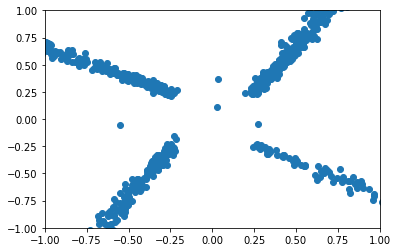

In [23]:
plot_res = np.array(responses[1])
plt.scatter(plot_res.real, plot_res.imag)
plt.xlim(-1,1)
plt.ylim(-1,1)

In [24]:
def str_to_bytearray(string_data):
    new_data = []
    for i in range(0, len(string_data), 8):
        new_data.append(string_data[i:i+8])  

    int_data = [] 
    for i in new_data:
        int_data.append(int(i,2))

    return bytearray(int_data)

In [25]:
predict_long = ''
for res in responses:
    predict_long += iHamming74(iqpsk(res))#[strt:end]

In [26]:
data1 = np.concatenate((responses[0] , responses[1], responses[2], responses[3]))#[4*20:4*40]
#data1 = responses[0]

In [27]:
predict =iHamming74(iqpsk(data1))
actual = binary

print(len(data1))
print(len(predict))

correct = 0
for i, val in enumerate(predict):
    if val == actual[i]:
        correct += 1
        
print(correct/len(predict))
for i in range(2):
    print("est", predict[i*100:(i+1)*100])
    print("act", actual[i*100:(i+1)*100])
    print('')
    
printlen = math.floor(len(predict)/8)*8
print(printlen)
predict = predict[:printlen]

8188
9356
0.8467293715262932
est 0101000001111001001000000110100001100101011000010111001001110100001000000110100101110011001000000110
act 0100110101111001001000000110100001100101011000010111001001110100001000000110100101110011001000000110

est 0010011001010110000101110100011010010110111001100111001000000110011001110010011011110110110100100000
act 0010011001010110000101110100011010010110111001100111001000000110011001110010011011110110110100100000

9352


In [28]:
#print(decode_binary_to_text(actual))
str_to_bytearray(predict).decode('utf-8', 'replace')

'Py heart is beating from me, I am standing all alone, Please call me only if you are coming home, Waste another year flies by, Waste a night or two, You taught me how to live In the streets of shame, Where you\'ve lost your dreams in the rain, There\'s no signs of hope, The��t�ӗ���\x10�\x1a�2�\n��.�Dhe last of the dope, There\'s a glow of light, The St. Jimmy is the spark in the night, Bearing gifts and trust, The fixture in the city of lust, "What the hells your name, What\'s your pleasure and what\'s your pain? Do you dream too much? Do you think what you need is a cr�\x00-P��V��\x06\x03�����ªU�cf pain, St. Jimmy comes without any shame, He says "We\'re *****ed up", But we\'re not the same, And mom and dad are the ones you can blame Jimmy died today He blew his brains out into the bay, In the state of mind in my own private suicide Well nobody cares, Well nobody carE\x08��\x04�/���y�\x1e#5�L�+��S��\'��u�jǔm.\x16�\x1f<\t��7Gn0H��n\x156�>��t��R�Zə\x0b��l�\x1d��%�T)��}��*�l�l�D4�\\?�\x